#GAN CGAN 과제

##0. 라이브러리 임포트 및 환경 설정

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms.functional as TF

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

torch.manual_seed(42)
if device == "cuda":
    torch.cuda.manual_seed_all(42)

Device: cuda


##1. CIFAR100 데이터셋 로딩 및 전처리

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 128
trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                         download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

classes = trainset.classes
print("Total classes:", len(classes))

Total classes: 100


/usr/gatoai/python/venv/pytorch-2.6.0-cuda12.4-py3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


##2. 이미지 시각화

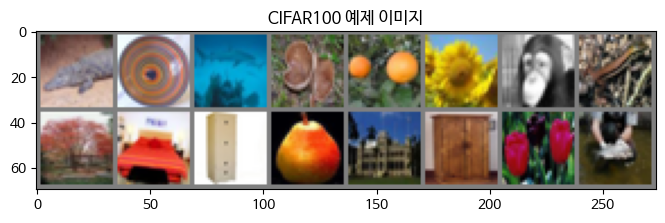

In [ ]:
def imshow(img, title=None):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:16]), title="CIFAR100 예제 이미지")

##3. GAN Generator 구현

In [ ]:
class GANGenerator(nn.Module):
    def __init__(self, nz=100, ngf=64, nc=3):
        super(GANGenerator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

netG = GANGenerator().to(device)
print(netG)

GANGenerator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )

##4. GAN Discriminator 구현

In [ ]:
class GANDiscriminator(nn.Module):
    def __init__(self, nc=3, ndf=64):
        super(GANDiscriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1)

netD = GANDiscriminator().to(device)
print(netD)

GANDiscriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


##5. GAN 학습

In [ ]:
nz = 100
lr = 0.0002
beta1 = 0.5
num_epochs = 25

criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

def resize_batch(batch, size=(64,64)):
    return torch.stack([TF.resize(img, size) for img in batch])

print("=== GAN 학습 시작 ===")
for epoch in range(num_epochs):
    for i, (data, _) in enumerate(trainloader):
        netD.zero_grad()
        real_imgs = resize_batch(data).to(device)
        b_size = real_imgs.size(0)
        label = torch.full((b_size,), 1., dtype=torch.float, device=device)
        output = netD(real_imgs)
        errD_real = criterion(output, label)
        errD_real.backward()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_imgs = netG(noise)
        label.fill_(0.)
        output = netD(fake_imgs.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        optimizerD.step()
        errD = errD_real + errD_fake

        netG.zero_grad()
        label.fill_(1.)
        output = netD(fake_imgs)
        errG = criterion(output, label)
        errG.backward()
        optimizerG.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Step [{i}/{len(trainloader)}] Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f}")
print("=== GAN 학습 종료 ===")

=== GAN 학습 시작 ===
Epoch [1/25] Step [0/391] Loss_D: 1.4530 Loss_G: 3.3436
Epoch [1/25] Step [100/391] Loss_D: 0.3405 Loss_G: 3.9915
Epoch [1/25] Step [200/391] Loss_D: 0.7052 Loss_G: 4.3343
Epoch [1/25] Step [300/391] Loss_D: 0.4969 Loss_G: 2.5653
Epoch [2/25] Step [0/391] Loss_D: 0.5597 Loss_G: 5.1914
Epoch [2/25] Step [100/391] Loss_D: 0.4442 Loss_G: 4.0358
Epoch [2/25] Step [200/391] Loss_D: 0.6593 Loss_G: 2.1918
Epoch [2/25] Step [300/391] Loss_D: 0.8035 Loss_G: 2.0336
Epoch [3/25] Step [0/391] Loss_D: 0.4363 Loss_G: 2.8052
Epoch [3/25] Step [100/391] Loss_D: 0.4533 Loss_G: 4.3691
Epoch [3/25] Step [200/391] Loss_D: 0.3594 Loss_G: 4.0619
Epoch [3/25] Step [300/391] Loss_D: 0.3322 Loss_G: 2.8914
Epoch [4/25] Step [0/391] Loss_D: 1.2269 Loss_G: 1.3052
Epoch [4/25] Step [100/391] Loss_D: 0.5094 Loss_G: 1.6809
Epoch [4/25] Step [200/391] Loss_D: 0.2857 Loss_G: 3.7927
Epoch [4/25] Step [300/391] Loss_D: 0.6193 Loss_G: 1.7503
Epoch [5/25] Step [0/391] Loss_D: 0.2033 Loss_G: 3.4582
Epoch 

##6. GAN 생성 이미지 시각화

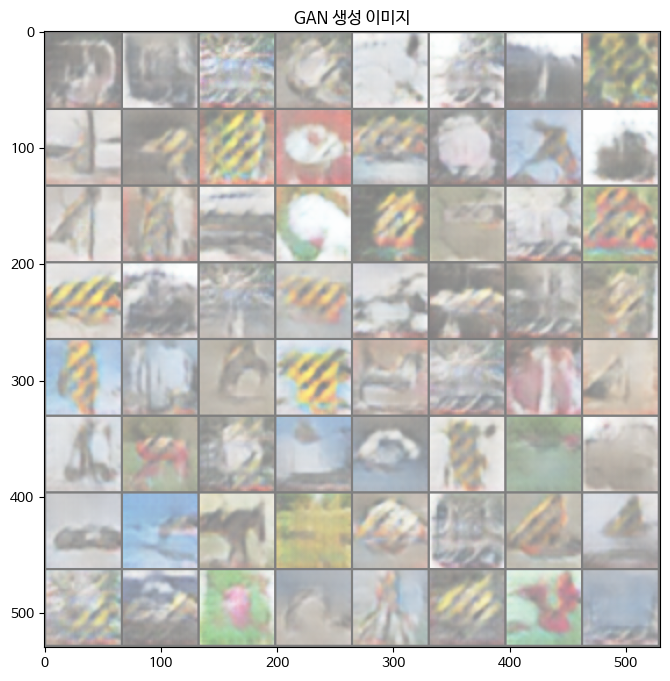

In [ ]:
with torch.no_grad():
    fixed_noise = torch.randn(64, nz, 1, 1, device=device)
    fake_imgs = netG(fixed_noise).detach().cpu()

imshow(torchvision.utils.make_grid(fake_imgs, padding=2, normalize=True), title="GAN 생성 이미지")

##7. CGAN Generator 구현

In [ ]:
class CGANGenerator(nn.Module):
    def __init__(self, nz=100, ngf=64, nc=3, n_classes=100, embed_size=50):
        super(CGANGenerator, self).__init__()
        self.label_emb = nn.Embedding(n_classes, embed_size)
        self.init_size = 4
        self.l1 = nn.Sequential(nn.Linear(nz + embed_size, ngf * 8 * self.init_size * self.init_size))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(ngf * 8),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        if noise.dim() > 2:
            noise = noise.view(noise.size(0), -1)
        label_embedding = self.label_emb(labels)
        gen_input = torch.cat((noise, label_embedding), dim=1)
        out = self.l1(gen_input)
        out = out.view(out.size(0), -1, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

netG_cgan = CGANGenerator().to(device)
print(netG_cgan)

CGANGenerator(
  (label_emb): Embedding(100, 50)
  (l1): Sequential(
    (0): Linear(in_features=150, out_features=8192, bias=True)
  )
  (conv_blocks): Sequential(
    (0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
   

##8. CGAN Discriminator 구현

In [ ]:
class CGANDiscriminator(nn.Module):
    def __init__(self, nc=3, ndf=64, n_classes=100, embed_size=128):
        super(CGANDiscriminator, self).__init__()
        self.label_emb = nn.Embedding(n_classes, embed_size)
        self.conv = nn.Sequential(
            nn.Conv2d(nc + embed_size, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False)
        )

    def forward(self, img, labels):
        label_embedding = self.label_emb(labels)
        label_embedding = label_embedding.unsqueeze(2).unsqueeze(3)
        label_embedding = label_embedding.repeat(1, 1, img.size(2), img.size(3))
        d_in = torch.cat((img, label_embedding), 1)
        out = self.conv(d_in)
        return torch.sigmoid(out.view(out.size(0), -1).mean(1))

netD_cgan = CGANDiscriminator().to(device)
print(netD_cgan)

CGANDiscriminator(
  (label_emb): Embedding(100, 128)
  (conv): Sequential(
    (0): Conv2d(131, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)


##9. CGAN 학습

In [ ]:
nz = 100
lr_d = 0.0002
lr_g = 0.0003
beta1 = 0.5
num_epochs = 25

criterion = nn.BCELoss()
optimizerD_cgan = optim.Adam(netD_cgan.parameters(), lr=lr_d, betas=(beta1, 0.999))
optimizerG_cgan = optim.Adam(netG_cgan.parameters(), lr=lr_g, betas=(beta1, 0.999))

print("=== CGAN 학습 시작 ===")
for epoch in range(num_epochs):
    for i, (data, labels) in enumerate(trainloader):
        real_imgs = resize_batch(data).to(device)
        labels = labels.to(device)
        b_size = real_imgs.size(0)

        netD_cgan.zero_grad()
        label_real = torch.full((b_size,), 0.9, dtype=torch.float, device=device)
        output_real = netD_cgan(real_imgs, labels)
        errD_real = criterion(output_real, label_real)
        errD_real.backward()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_imgs = netG_cgan(noise, labels)
        label_fake = torch.full((b_size,), 0., dtype=torch.float, device=device)
        output_fake = netD_cgan(fake_imgs.detach(), labels)
        errD_fake = criterion(output_fake, label_fake)
        errD_fake.backward()
        optimizerD_cgan.step()
        errD = errD_real + errD_fake

        netG_cgan.zero_grad()
        label_gen = torch.full((b_size,), 0.9, dtype=torch.float, device=device)
        output = netD_cgan(fake_imgs, labels)
        errG = criterion(output, label_gen)
        errG.backward()
        optimizerG_cgan.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Step [{i}/{len(trainloader)}] Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f}")
print("=== CGAN 학습 종료 ===")

=== CGAN 학습 시작 ===
Epoch [1/25] Step [0/391] Loss_D: 1.4081 Loss_G: 0.8840
Epoch [1/25] Step [100/391] Loss_D: 1.3997 Loss_G: 0.8347
Epoch [1/25] Step [200/391] Loss_D: 1.3779 Loss_G: 0.8281
Epoch [1/25] Step [300/391] Loss_D: 1.3464 Loss_G: 0.8330
Epoch [2/25] Step [0/391] Loss_D: 1.3685 Loss_G: 0.8198
Epoch [2/25] Step [100/391] Loss_D: 1.3914 Loss_G: 0.8016
Epoch [2/25] Step [200/391] Loss_D: 1.3545 Loss_G: 0.8125
Epoch [2/25] Step [300/391] Loss_D: 1.3407 Loss_G: 0.8347
Epoch [3/25] Step [0/391] Loss_D: 1.3463 Loss_G: 0.8161
Epoch [3/25] Step [100/391] Loss_D: 1.4152 Loss_G: 0.7923
Epoch [3/25] Step [200/391] Loss_D: 1.3837 Loss_G: 0.7894
Epoch [3/25] Step [300/391] Loss_D: 1.3570 Loss_G: 0.8108
Epoch [4/25] Step [0/391] Loss_D: 1.3419 Loss_G: 0.8002
Epoch [4/25] Step [100/391] Loss_D: 1.3826 Loss_G: 0.7861
Epoch [4/25] Step [200/391] Loss_D: 1.3855 Loss_G: 0.7897
Epoch [4/25] Step [300/391] Loss_D: 1.3772 Loss_G: 0.7874
Epoch [5/25] Step [0/391] Loss_D: 1.3557 Loss_G: 0.8165
Epoch

##10. CGAN 생성 이미지 시각화

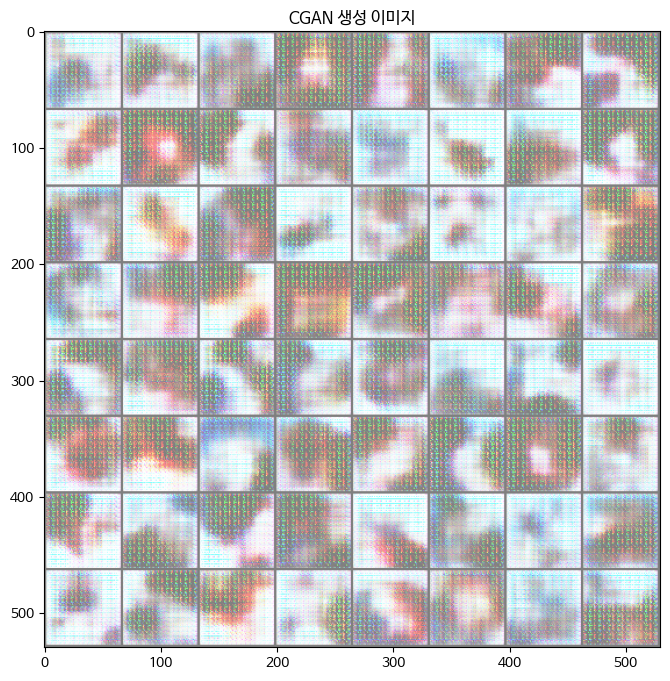

In [ ]:
with torch.no_grad():
    fixed_noise = torch.randn(64, nz, 1, 1, device=device)
    # 예시: 무작위로 선택한 레이블 사용 (원하는 클래스 고정 가능)
    fixed_labels = torch.randint(0, 100, (64,), device=device)
    fake_imgs_cgan = netG_cgan(fixed_noise, fixed_labels).detach().cpu()

imshow(torchvision.utils.make_grid(fake_imgs_cgan, padding=2, normalize=True), title="CGAN 생성 이미지")

## 어려웠던 점

- CGAN은 클래스 조건이 반영되어 특정 클래스 특징이 뚜렷하게 나타날 것이라 예상하였는데 아니었다.

- CGAN 모델에서 조건 정보를 반영하려는 시도에도 불구하고 생성된 이미지에 심한 노이즈가 나타났다.

- 생성 네트워크와 판별 네트워크의 균형 유지가 어려웠다. 생성자와 판별자의 경쟁 과정에서 미세한 하이퍼파라미터 조정에도 민감하여, 한쪽이 과도하게 우세해지면 전체 학습 과정이 불안정해졌다.




##분석 및 고찰

### GAN 아키텍처

- 생성자가 특정 몇 가지 패턴에 지나치게 집중하여 다양한 샘플을 생성하지 못하는 모드 콜랩스가 발생하여 비슷한 이미지가 많이 생성되었다.


### CGAN 아키텍처

- CGAN 모델의 경우, 조건 정보를 반영하려는 시도에도 불구하고 생성된 이미지에 심한 노이즈가 나타났다.

- 라벨링 임베딩을 이미지와 단순히 채널 방향으로 결합하는 방식이 조건 정보를 충분히 반영하지 못하고, 오히려 노이즈를 만드는 결과를 초래한 것 같다.

###결론
  
- 두 모델 모두 각기 다른 문제점을 보이고 있으며, GAN은 다양성 확보에, CGAN은 조건 반영과 노이즈 제어에 어려움이 있음을 확인할 수 있었습니다.  

- 향후 학습에서는 다양한 GAN 변형 모델(WGAN, StyleGAN 등)과 같은 최신 기법들을 실험해 보는 것이 도움이 될 것 같다.